# Campina - Ceilometer
## Script to generate figures for the ATTO weekly report

### Author: Henrique Barbosa
### First version: 17-Jun-2022
### Last update: 6-Feb-2025

In [15]:
# Load all the necessary libraries

import datetime
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
# We'll use xarray for reading the data, so netCDF4 is not needed
#import netCDF4 as nc
import xarray as xr
import os
import glob

In [16]:
# Define the dates for the report
y0='2024'; m0='11'; d0='1';  # -3 weeks
y1='2024'; m1='11'; d1='17'; # -1 week
y2='2024'; m2='11'; d2='24'; # yesterday

w2 = datetime.date(int(y2), int(m2), int(d2)).isocalendar().week

# title for 3-week plots: YYYY weeks W-2, W-1, W
w02 = y2 + ' weeks ' + str(w2-2) + ', ' + str(w2-1) + ', ' + str(w2)

# title for 1-week plots: YYYY week W
w12 = y2 + ' week ' + str(w2)

# replace spaces/commas with _ to use in filenames save to disk
w02tit = w02.replace(',', '').replace(' ', '_')
w12tit = w12.replace(',', '').replace(' ', '_')

print('This is week: ', w2, ' of year: ', y2)

This is week:  47  of year:  2024


In [17]:
# Download/update the data files saved on this computer
# Remember to change the month/folder

# WARN: the "-c" option will attempt to continue the download of a previously existing file. 
#   I'm not sure if that works with netCDF files. 
# 
# ISSUE: When we download the data, the current day will be only partially complete. Hence, 
#   when you try to update the files (next week), what happens to this partial file? 
#   If there are special markers at the end of a netCDF file, then copying just the remaining 
#   bytes to "complete" the file would not work. 
#
# SOLUTION (to be done): We should check more appropriate options for WGET
#   so that modified files get fully updated, and unmodified files are not downloaded again. 
#
# REMEDY: 
#   After updated the data files, the current day should be delete. 

# Define the local folder storing the data
basedir = '/Users/hbarbosa/DATA/ATTO_ceilo_camp/Ceilometer/'

# wget -r -c -np -nH --cut-dirs=6 -R "*.dat" -R "index.html*" http://floresta.if.usp.br/ftp/public/ATTO/Campina/Ceilometer/2022/06/ -P /Users/hbarbosa/DATA/ATTO_ceilo_camp/Ceilometer/2022


In [2]:
# Create a list of all files
# Plots for the report use the last 3 weeks, so some data might be from the previous month. 
allfiles = sorted(glob.glob(basedir + y0 + '/' + m0 + '/' + '*.nc'))
if (int(m0) != int(m2) ):
    allfiles += sorted(glob.glob(basedir + y2 + '/' + m2 + '/' + '*.nc'))

# The list of files includes everything within 2 months, but we only want a 3-week range
files = []
for i in range(len(allfiles)):
    # get the date from the filename 
    tmp = os.path.basename(allfiles[i])[:8] 
    # ATTO report dates are inclusive 
    if ( (tmp >= y0+m0+d0) & (tmp <= y2+m2+d2) ):
        files.append(allfiles[i])
        #print(os.path.basename(allfiles[i]))
        
print(files[0])
print(files[-1])

/Users/hbarbosa/DATA/ATTO_ceilo_camp/Ceilometer/2024/11/20241110_ATTO_CHM160146_000.nc
/Users/hbarbosa/DATA/ATTO_ceilo_camp/Ceilometer/2024/11/20241120_ATTO_CHM160146.nc


In [3]:
# https://stackoverflow.com/questions/47226429/join-merge-multiple-netcdf-files-using-xarray

#ds = xr.merge([xr.open_dataset(f) for f in files])

# MF (multi-file) dataset is much faster than trying to merge the files
ds = xr.open_mfdataset(files)

# Create the plots with control/diagnostics

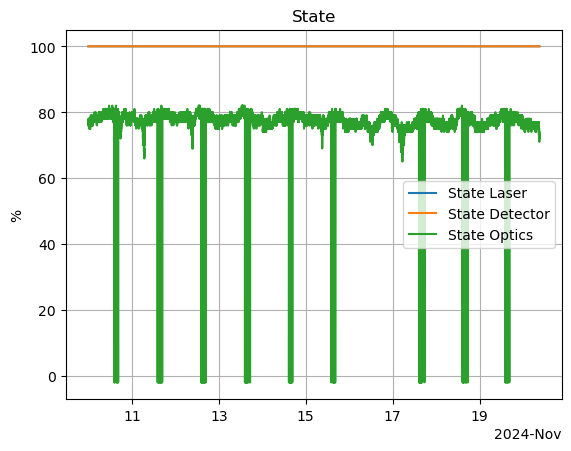

In [4]:
plt.plot(ds['time'], ds['state_laser'], label='State Laser')
plt.plot(ds['time'], ds['state_detector'], label='State Detector')
plt.plot(ds['time'], ds['state_optics'], label='State Optics')
plt.ylabel('%')
plt.title('State')
plt.legend()
plt.grid('on')
locator=mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

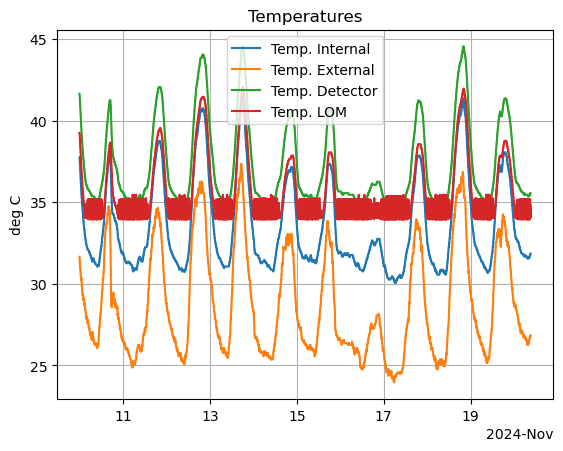

In [5]:
plt.plot(ds['time'], ds['temp_int']-273.15, label='Temp. Internal')
plt.plot(ds['time'], ds['temp_ext']-273.15, label='Temp. External')
plt.plot(ds['time'], ds['temp_det']-273.15, label='Temp. Detector')
plt.plot(ds['time'], ds['temp_lom']-273.15, label='Temp. LOM')
plt.ylabel('deg C')
plt.title('Temperatures')
plt.legend()
plt.grid('on')
locator=mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

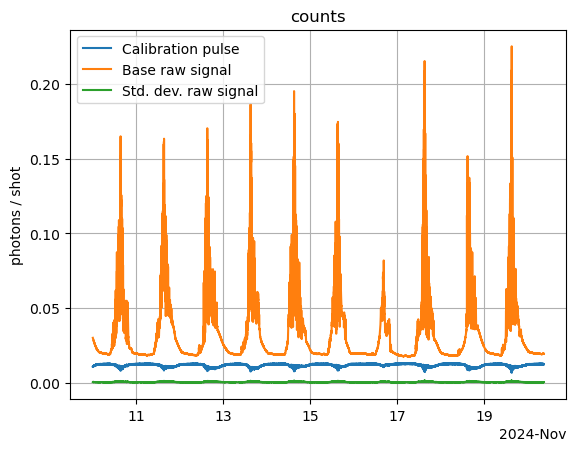

In [6]:
plt.plot(ds['time'], ds['p_calc'], label='Calibration pulse')
plt.plot(ds['time'], ds['base'  ], label='Base raw signal')
plt.plot(ds['time'], ds['stddev'], label='Std. dev. raw signal')
plt.ylabel('photons / shot')
plt.title('counts')
plt.legend()
plt.grid('on')
locator=mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

## Create plots for the report

### (1) cloud base height, 3 weeks

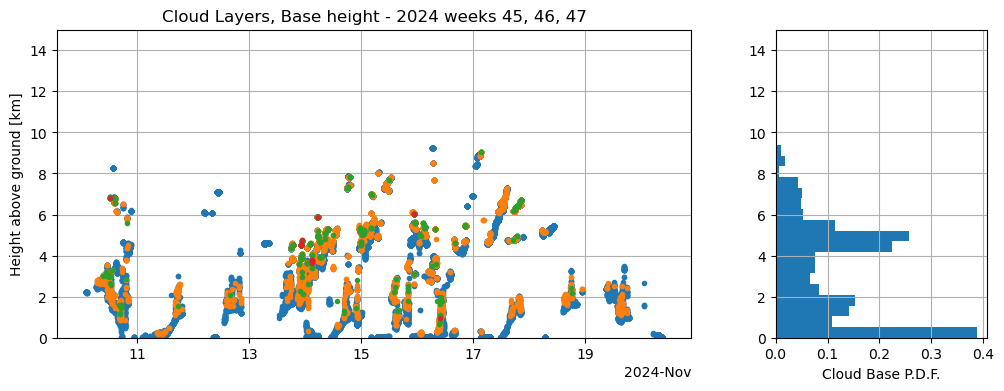

In [7]:
# variable Cloud Base Height (CBH) is in meters => km
tmp = ds['cbh'].values.astype(float) / 1e3
tmp[tmp < 0] = np.nan

fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3,1]})
fig.set_figheight(4)
fig.set_figwidth(12)

ax1.plot(ds['time'], tmp,'.')
ax1.set(ylabel='Height above ground [km]')
ax1.grid('on')
ax1.set_ylim([0, 15])
locator=mdates.AutoDateLocator()
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax1.set_title('Cloud Layers, Base height - ' + w02)

ax2.hist(tmp.flatten(), bins=np.linspace(0,12,24), density=True, orientation='horizontal')
ax2.grid('on')
ax2.set_ylim([0, 15])
ax2.set(xlabel='Cloud Base P.D.F.')

plt.savefig('Atto_Ceilometer_CloudBase_'+w02tit+'.png', 
            dpi=150, format='png', facecolor='white', bbox_inches='tight')

### (2) cloud base height, 1 week

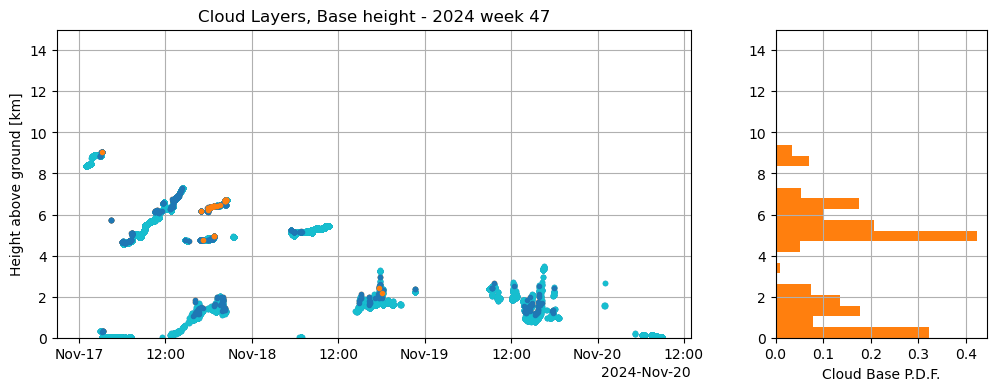

In [8]:
tmp = ds['cbh'].values.astype(float) / 1e3
tmp[tmp < 0] = np.nan
time = ds['time']
t1 = np.datetime64(y1+'-'+m1+'-'+d1)

fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3,1]})
fig.set_figheight(4)
fig.set_figwidth(12)

ax1.plot(time[time>=t1], tmp[time>=t1,:],'.')

ax1.set(ylabel='Height above ground [km]')
ax1.grid('on')
ax1.set_ylim([0, 15])
locator=mdates.AutoDateLocator()
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax1.set_title('Cloud Layers, Base height - ' + w12)

ax2.hist(tmp[time>=t1,:].flatten(), bins=np.linspace(0,12,24), density=True, orientation='horizontal')
ax2.grid('on')
ax2.set_ylim([0, 15])
ax2.set(xlabel='Cloud Base P.D.F.')

ax1.plot(time[time>=t1], tmp[time>=t1,:],'.')
ax1.set(ylabel='Height above ground [km]')
ax1.grid('on')
ax1.set_ylim([0, 15])
locator=mdates.AutoDateLocator()
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax1.set_title('Cloud Layers, Base height - ' + w12)

ax2.hist(tmp[time>=t1,:].flatten(), bins=np.linspace(0,12,24), density=True, orientation='horizontal')
ax2.grid('on')
ax2.set_ylim([0, 15])
ax2.set(xlabel='Cloud Base P.D.F.')

plt.savefig('Atto_Ceilometer_CloudBase_'+w12tit+'.png', 
            dpi=150, format='png', facecolor='white', bbox_inches='tight')

### (3) raw signal (betaraw), 3 weeks

In [9]:
# Apply a 5-min average, and reduce the vertical resolution by a factor of 4 
betaraw = ds['beta_raw'].resample(time='5Min').mean().coarsen(range=4).mean()

# get the new altitudes and times
altitudes = betaraw['range']/1e3
time = betaraw['time']
t1 = np.datetime64(y1+'-'+m1+'-'+d1)

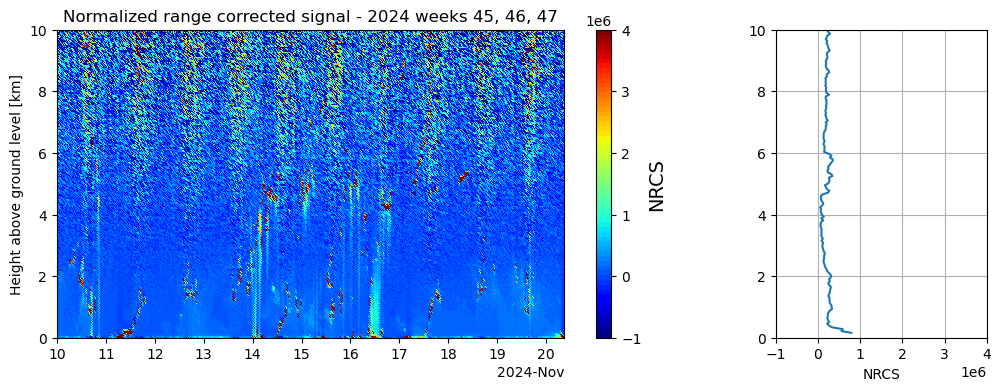

In [10]:
# This is the plot for 3 weeks
fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3,1]})
fig.set_figheight(4)
fig.set_figwidth(12)

# If needed, you can adjust the max/min for betaraw and altitude 

# in betaraw units
vmin=-1e6
vmax=4e6

# in km
maxalt=10.

betatime = betaraw['time'].values
CS = ax1.pcolormesh(betatime, 
                    betaraw['range']*np.cos(ds.zenith[0]*np.pi/180.)/1e3, 
                    betaraw.T, 
               cmap=plt.get_cmap('jet',64), vmin=vmin, vmax=vmax, 
               shading='nearest', edgecolors='face')
ax1.set(ylabel='Height above ground level [km]')
ax1.set_ylim([0, maxalt])
locator=mdates.AutoDateLocator()
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax1.set_title('Normalized range corrected signal - ' + w02)

cb = plt.colorbar(CS, ax=ax1)
cb.set_label(label = 'NRCS', fontsize=14)

ax2.plot(np.mean(betaraw[:,2:], axis=0), betaraw['range'][2:]/1e3)
ax2.grid('on')
ax2.set(xlabel='NRCS')
ax2.set_xlim([vmin, vmax])
ax2.set_ylim([0, maxalt])

plt.savefig('Atto_Ceilometer_Signal_'+w02tit+'.png', 
            dpi=150, format='png', facecolor='white', bbox_inches='tight')

### (4) raw signal (betaraw), 1 week

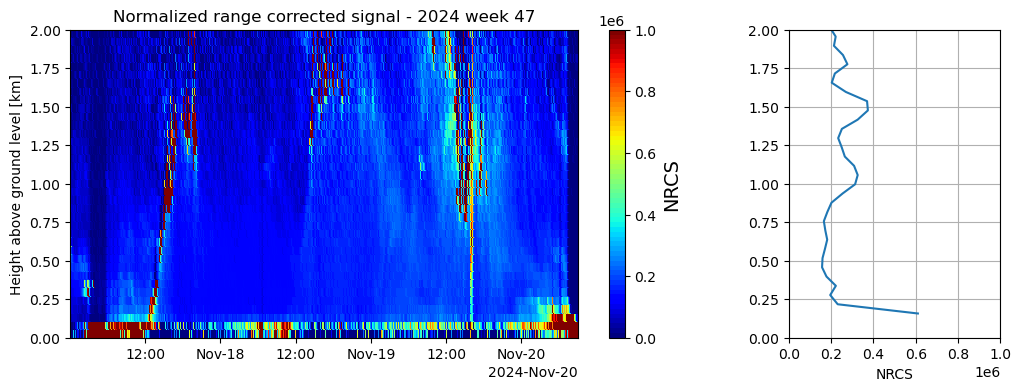

In [22]:
# the data was already resampled, so we don't have to do it again

fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3,1]})
fig.set_figheight(4)
fig.set_figwidth(12)

# It would be better to use the same limits as above, but just in case: 
vmin=-1e6
vmax=4e6
maxalt=10.

betatime = betaraw['time'].values
CS = ax1.pcolormesh(betatime[betatime>t1], 
                    betaraw['range']*np.cos(ds.zenith[0]*np.pi/180.)/1e3, 
                    betaraw.T[:,betatime>t1], 
               cmap=plt.get_cmap('jet',64), vmin=vmin, vmax=vmax, 
               shading='nearest', edgecolors='face')
ax1.set(ylabel='Height above ground level [km]')
ax1.set_ylim([0, maxalt])
locator=mdates.AutoDateLocator()
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax1.set_title('Normalized range corrected signal - ' + w12)

cb = plt.colorbar(CS, ax=ax1)
cb.set_label(label = 'NRCS', fontsize=14)

ax2.plot(np.mean(betaraw[betatime>t1,2:], axis=0), betaraw['range'][2:]/1e3)
ax2.grid('on')
ax2.set(xlabel='NRCS')
ax2.set_xlim([vmin, vmax])
ax2.set_ylim([0, maxalt])

plt.savefig('Atto_Ceilometer_Signal_'+w12tit+'.png', 
            dpi=150, format='png', facecolor='white', bbox_inches='tight')